<a href="https://colab.research.google.com/github/avantika0111/COVID-19-Detection-Using-Chest-X-Ray-Images/blob/master/COVID_19_Detection_Using_Chest_X_Ray_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing The Libraries

In [ ]:
from imutils import paths
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# Importing Data From Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset = "/content/drive/My Drive/Data"

In [ ]:
args={}
args["dataset"]=dataset

# Extracting Data From Dataset

In [ ]:
img_path = list(paths.list_images(args["dataset"]))
data = []
labels = []
for i in img_path:
  label = i.split(os.path.sep)[-2]
  image = cv2.imread(i)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    # converting images into RGB 
  image = cv2.resize(image, (224, 224))     #resizing image
  data.append(image)
  labels.append(label)
data = np.array(data) / 255.0
labels = np.array(labels)

In [ ]:
data

array([[[[0.        , 0.00392157, 0.00784314],
         [0.        , 0.00784314, 0.        ],
         [0.00392157, 0.        , 0.        ],
         ...,
         [0.78039216, 0.78039216, 0.78039216],
         [0.75686275, 0.75686275, 0.75686275],
         [0.79607843, 0.79607843, 0.79607843]],

        [[0.        , 0.        , 0.        ],
         [0.00392157, 0.02352941, 0.        ],
         [0.        , 0.01568627, 0.00392157],
         ...,
         [0.81176471, 0.81176471, 0.81176471],
         [0.80392157, 0.80392157, 0.80392157],
         [0.8       , 0.8       , 0.8       ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.85882353, 0.85882353, 0.85882353],
         [0.85882353, 0.85882353, 0.85882353],
         [0.83921569, 0.83921569, 0.83921569]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]

# Analysing Data

In [ ]:
covid_images = os.listdir(dataset + "//Covid")
normal_images = os.listdir(dataset + "//Normal")

Normal Chest X-ray Vs Covid-19 Chest X-ray


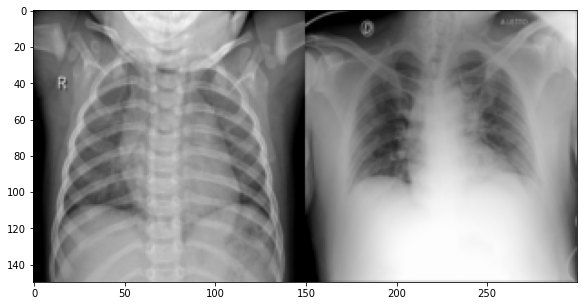

Normal Chest X-ray Vs Covid-19 Chest X-ray


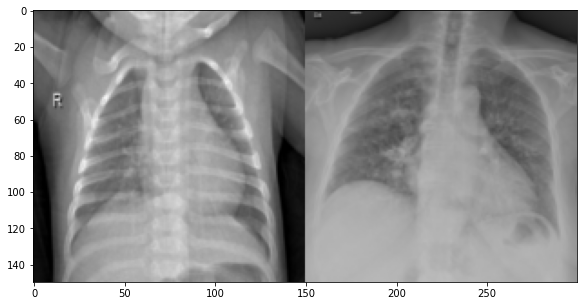

Normal Chest X-ray Vs Covid-19 Chest X-ray


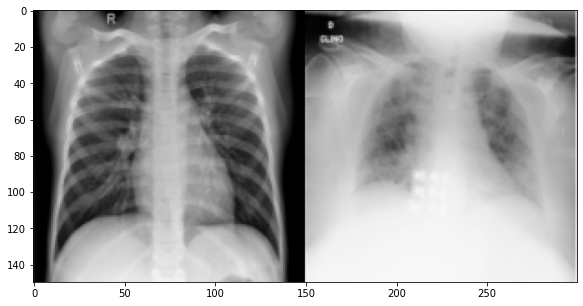

In [ ]:
from skimage.transform import resize

def plot(i):
  normal = cv2.imread(dataset +"//Normal//"+normal_images[i])
  normal = resize(normal, (150, 150, 3))
  coronavirus = cv2.imread(dataset +"//Covid//"+covid_images[i])
  coronavirus = resize(coronavirus, (150, 150, 3) , mode = 'reflect')
  pair = np.concatenate((normal, coronavirus), axis=1)
  print("Normal Chest X-ray Vs Covid-19 Chest X-ray")
  plt.figure(figsize=(10,5))
  plt.imshow(pair)
  plt.show()

for i in range(0, 3):
  plot(i)

# Binarizing the Labels

In [ ]:
binarizer = LabelBinarizer()
labels = binarizer.fit_transform(labels)
labels = to_categorical(labels)

#Splitting the dataset and increasing test data size using Data Augmentation

In [ ]:
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels, test_size = 0.2, random_state = 42, stratify = labels)
trainAug = ImageDataGenerator(rotation_range=15, fill_mode='nearest')

In [ ]:
trainAug

# Applying Transfer Learning

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape= (224,224,3)))
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(4,4))(head_model)
head_model = Flatten(name='flatten')(head_model)
head_model = Dense(64, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation="softmax")(head_model)
model = Model(inputs=base_model.input, outputs=head_model)

for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
INIT_LR = 1e-3
EPOCHS = 10
BS = 8

#Training the VGG-16 Model

In [15]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
print("Compilation Starts")
R = model.fit_generator(
    trainAug.flow(X_train, Y_train, batch_size=BS),
    steps_per_epoch=len(X_train) // BS,
    validation_data=(X_test, Y_test),
    validation_steps=len(X_test) // BS,
    epochs=EPOCHS)

Compilation Starts
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
20/20 [==============================] - 97s 5s/step - loss: 0.7669 - accuracy: 0.5125 - val_loss: 0.5825 - val_accuracy: 0.8250
Epoch 2/10
20/20 [==============================] - 96s 5s/step - loss: 0.5463 - accuracy: 0.7437 - val_loss: 0.4948 - val_accuracy: 0.9000
Epoch 3/10
20/20 [==============================] - 97s 5s/step - loss: 0.4443 - accuracy: 0.8813 - val_loss: 0.4040 - val_accuracy: 0.9750
Epoch 4/10
20/20 [==============================] - 96s 5s/step - loss: 0.3235 - accuracy: 0.9438 - val_loss: 0.3185 - val_accuracy: 0.9750
Epoch 5/10
20/20 [==============================] - 101s 5s/step - loss: 0.2908 - accuracy: 0.9250 - val_loss: 0.2600 - val_accuracy: 1.0000
Epoch 6/10
20/20 [==============================] - 96s 5s/step - loss: 0.2227 - accuracy: 0.9625 - val_loss: 0.2113 - val_accuracy: 1.0000
Epoch 7/10
20/20 [==============================] - 96s 5s/step 

# Visualizing Results on Test Data

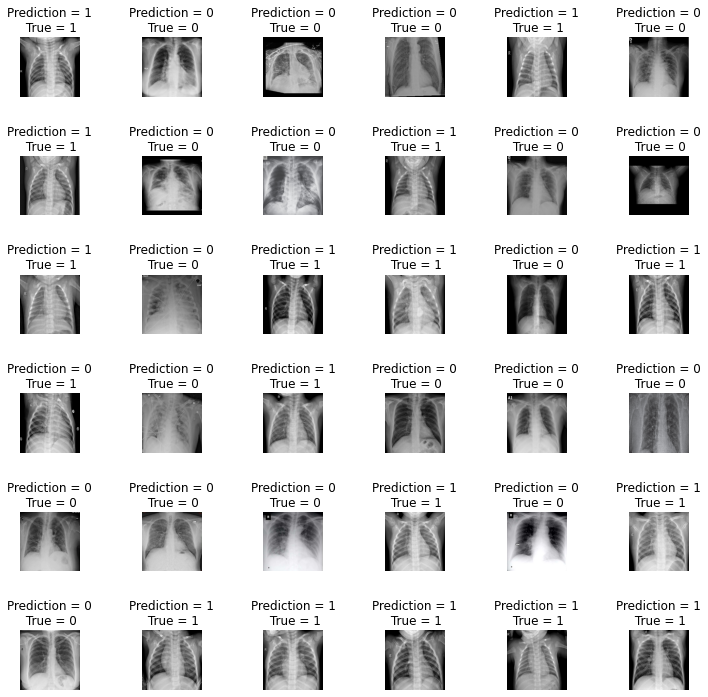

In [16]:
L = 6
W = 6
fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()
y_pred = model.predict(X_test, batch_size=BS)
for i in np.arange(0,L*W):
    axes[i].imshow(X_test[i])
    axes[i].set_title('Prediction = {}\n True = {}'.format(y_pred.argmax(axis=1)[i], Y_test.argmax(axis=1)[i]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1, hspace=1)

# Analysing Model through Clasification Report and Confusion Matrix

In [17]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test, batch_size=BS)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(Y_test.argmax(axis=1), y_pred,target_names=binarizer.classes_))

              precision    recall  f1-score   support

       Covid       0.95      1.00      0.98        20
      Normal       1.00      0.95      0.97        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



In [18]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test.argmax(axis=1),y_pred)

0.975

In [19]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test.argmax(axis=1), y_pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[20  0]
 [ 1 19]]
acc: 0.9750
sensitivity: 1.0000
specificity: 0.9500


# Plotting The Graphs

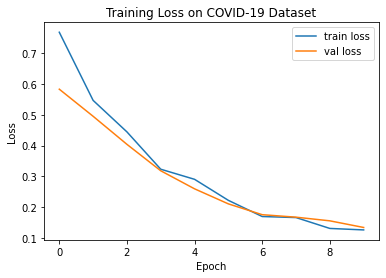

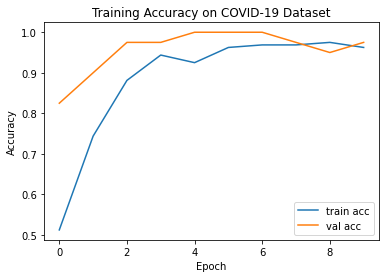

In [20]:
# plot the loss
plt.plot(R.history['loss'], label='train loss')
plt.plot(R.history['val_loss'], label='val loss')
plt.title('Training Loss on COVID-19 Dataset')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(R.history['accuracy'], label='train acc')
plt.plot(R.history['val_accuracy'], label='val acc')
plt.title('Training Accuracy on COVID-19 Dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Save The Model

In [21]:
model.save('Covid_19_Detection_model.h5')

# Testing Model On Single Images

Using TensorFlow backend.


Prediction: Corona


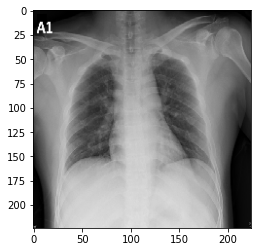

In [22]:
import tensorflow as tf 
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model = tf.keras.models.load_model('Covid_19_Detection_model.h5')

img = image.load_img('drive/My Drive/Data/Covid/1-s2.0-S1684118220300682-main.pdf-002-a1.png', 
                      target_size=(224, 224)) #insert a random covid-19 x-ray image
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)
New_pred = np.argmax(classes, axis=1)

if New_pred==[1]:
  print('Prediction: Normal')
else:
  print('Prediction: Corona')

Prediction: Normal


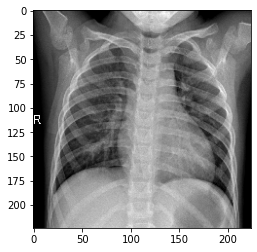

In [23]:
img = image.load_img('drive/My Drive/Data/Normal/IM-0162-0001.jpeg', 
                     target_size=(224, 224)) #insert a random normal x-ray image
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)
New_pred = np.argmax(classes, axis=1)

if New_pred==[1]:
  print('Prediction: Normal')
else:
  print('Prediction: Corona')